In [2]:
%pip install -qUq onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -qU git+https://github.com/ZFTurbo/Weighted-Boxes-Fusion.git#egg=ensemble_boxes

Note: you may need to restart the kernel to use updated packages.


In [4]:
from glob import glob
from os import path as osp

import cv2 as cv
import numpy as np
import onnxruntime


PATH_DATA = '/kaggle/input/project-p-dataset-beta'
PATH_MODELS = '/kaggle/input/projectp-yolov5-pytorch/runs/train/exp/weights'
NAME_MODEL = 'best.onnx'

SIZE = 512
OFFSET_X = 2
OFFSET_Y = 3

PATCH = np.s_[OFFSET_X * SIZE:OFFSET_X * SIZE + SIZE, OFFSET_Y * SIZE:OFFSET_Y * SIZE + SIZE, ...]

session = onnxruntime.InferenceSession(osp.join(PATH_MODELS, NAME_MODEL))

for filename in glob(osp.join(PATH_DATA, '*')):
    video = cv.VideoCapture(filename)
    if video.isOpened():
        while True:
            ok, frame = video.read()
            if not ok:
                break
            image = cv.cvtColor(frame[PATCH], cv.COLOR_BGR2RGB)
            batch = np.moveaxis(image, -1, 0)[None, ...] / np.float32(255)
            boxes = session.run(None, {session.get_inputs()[0].name: batch})[0][0]
            break
    video.release()
    break

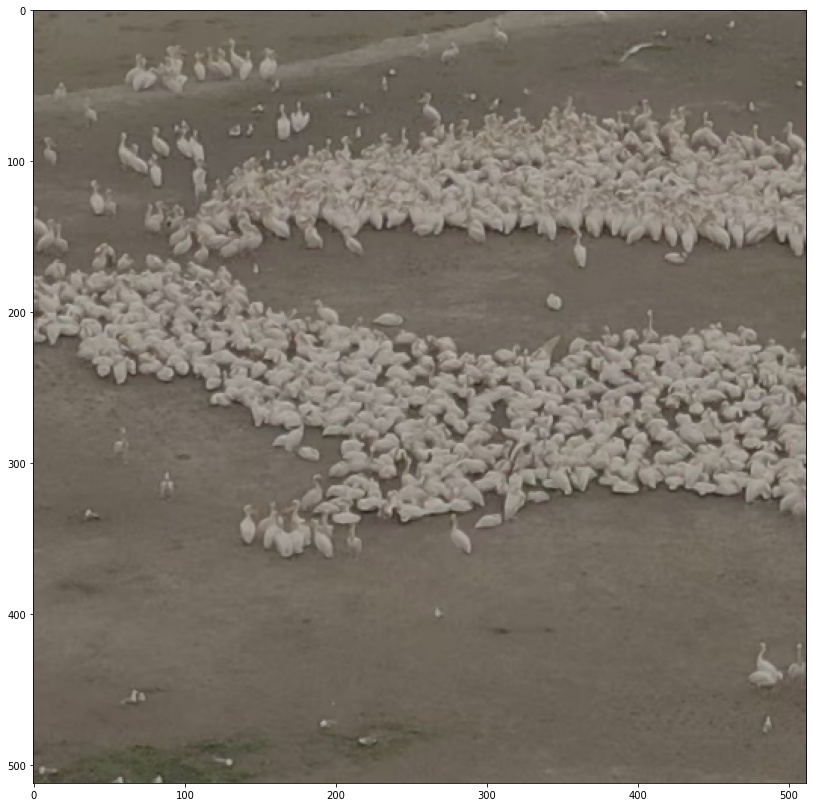

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(1024 / 72, 1024 / 72), dpi=72)
plt.imshow(image)

In [6]:
boxes.shape

(16128, 6)

In [7]:
boxes[:, 4].argsort()[::-1][:3]

array([ 9537,  1345, 10022])

In [8]:
boxes[boxes[:, 4].argsort()[::-1][:3]]

array([[ 15.94521   , 172.85803   ,  16.393175  ,  13.736683  ,
          0.84783256,   0.9999994 ],
       [ 15.349689  , 172.98112   ,  16.820295  ,  15.323463  ,
          0.845328  ,   0.9999992 ],
       [312.79266   , 228.51447   ,  15.84423   ,  11.394443  ,
          0.8398719 ,   0.9999995 ]], dtype=float32)

In [9]:
def nms(boxes, scores, thresh):
    '''
    dets is a numpy array : num_dets, 4
    scores is a  nump array : num_dets,
    '''
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1] # get boxes with more ious first

    keep = []
    while order.size > 0:
        i = order[0] # pick maxmum iou box
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1) # maximum width
        h = np.maximum(0.0, yy2 - yy1 + 1) # maxiumum height
        area = w * h
        overlap = area / (areas[i] + areas[order[1:]] - area)

        indices = np.where(overlap <= thresh)[0]
        order = order[indices + 1]

    return keep

In [10]:
boxes_abs = boxes.copy()

# boxes_abs[0]

boxes_abs[:, 0] -= boxes_abs[:, 2] / 2
boxes_abs[:, 1] -= boxes_abs[:, 3] / 2

boxes_abs[:, 2] += boxes_abs[:, 0]
boxes_abs[:, 3] += boxes_abs[:, 1]

# boxes_abs[:, :4] *= SIZE

boxes_abs[0]

array([-5.0716391e+00,  2.5984344e+00,  1.6257034e+01,  1.0911255e+01,
        1.2960732e-03,  9.9999583e-01], dtype=float32)

In [11]:
indices = nms(boxes_abs[:, :4], boxes_abs[:, 4], 0.175)

len(indices)

1268

In [12]:
# boxes[indices][:10]

In [13]:
# boxes[indices][-10:]

In [14]:
boxes_sorted = boxes_abs[indices]

len(boxes_sorted[boxes_sorted[:, 4] >= 0.005])

399

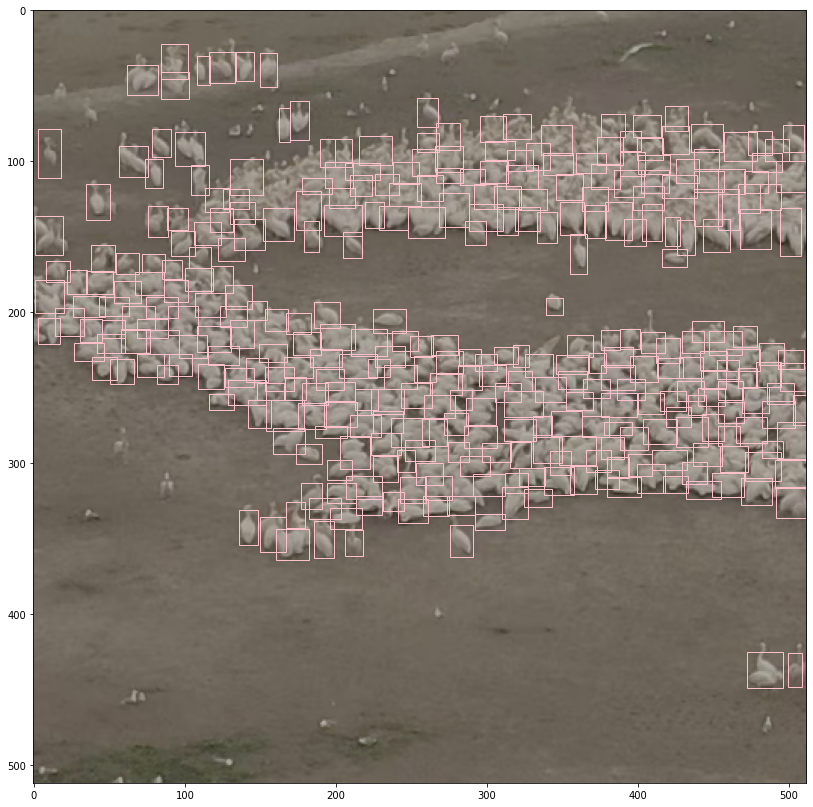

In [15]:
from matplotlib import patches


figure, axes = plt.subplots(figsize=(1024 / 72, 1024 / 72), dpi=72)
axes.imshow(image)
for bbox in boxes_sorted[boxes_sorted[:, 4] >= 0.1]:
    axes.add_patch(patches.Rectangle(bbox[:2], *(bbox[2:4] - bbox[:2]), linewidth=1,
                                     edgecolor='pink', facecolor='none'))
plt.show()

In [16]:
from ensemble_boxes import nms, weighted_boxes_fusion

In [17]:
boxes.shape

(16128, 6)

In [18]:
boxes[1612]

array([ 98.8222    , 205.06555   ,  19.208715  ,  21.661951  ,
         0.55742985,   0.99999917], dtype=float32)

In [19]:
boxes_norm = boxes.copy()

# Normalizing to 0..1 absolute

boxes_norm[:, 0] -= boxes_norm[:, 2] / 2
boxes_norm[:, 1] -= boxes_norm[:, 3] / 2

boxes_norm[:, 2] += boxes_norm[:, 0]
boxes_norm[:, 3] += boxes_norm[:, 1]

boxes_norm[:, 0:4:2] /= image.shape[1]
boxes_norm[:, 1:4:2] /= image.shape[0]

boxes_norm[1612]

array([0.1742536 , 0.3793644 , 0.21177062, 0.4216729 , 0.55742985,
       0.99999917], dtype=float32)

In [20]:
boxes_norm[:, :4][boxes_norm[:, :4] < 0].shape

(954,)

In [21]:
boxes_nms = nms(np.clip(boxes_norm[:, :4][None, ...], 0, 1),
                boxes_norm[:, 4][None, ...],
                boxes_norm[:, 5][None, ...].round(),
                0.175)

boxes_nms = np.column_stack(boxes_nms)


# Denormalizing
boxes_nms[:, 0:4:2] *= image.shape[1]
boxes_nms[:, 1:4:2] *= image.shape[0]

boxes_nms.shape

(1406, 6)

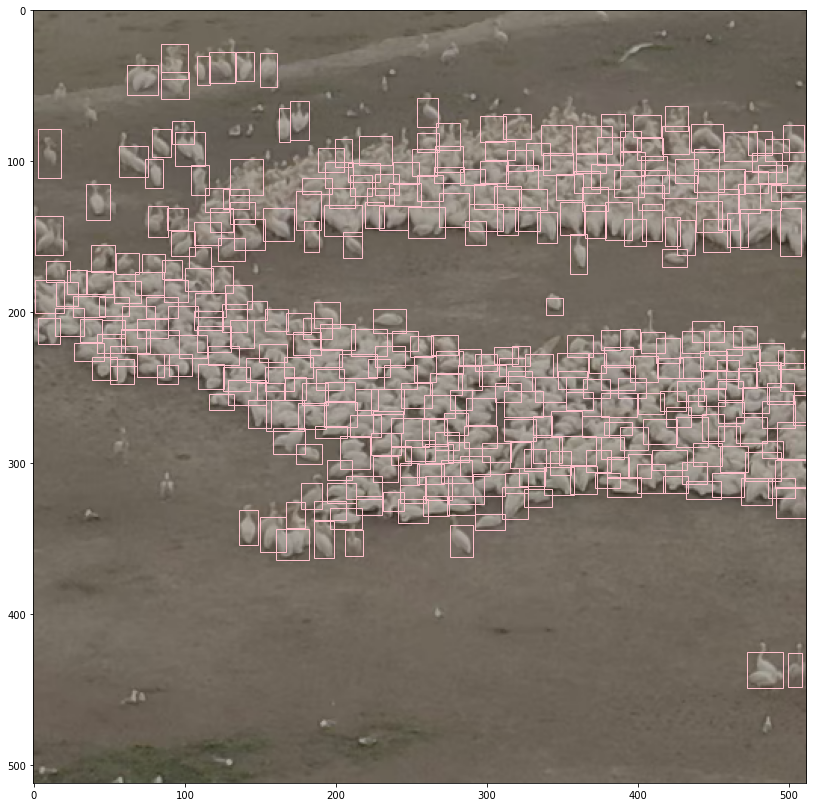

In [22]:
from matplotlib import patches


figure, axes = plt.subplots(figsize=(1024 / 72, 1024 / 72), dpi=72)
axes.imshow(image)
for bbox in boxes_nms[boxes_nms[:, 4] >= 0.1]:
    axes.add_patch(patches.Rectangle(bbox[:2], *(bbox[2:4] - bbox[:2]), linewidth=1,
                                     edgecolor='pink', facecolor='none'))
plt.show()

In [23]:
import math as m


class Tile:
    def __init__(self, x1, y1, x2, y2, bboxes=None):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.slice = np.s_[x1:x2, y1:y2, ...]
        self.bboxes = bboxes


def get_tiles(image, size_crop, verbose=False):
    width, height = image.shape[1::-1]

    assert tuple(image.shape[:2]) == (height, width)

    # bbcoords = np.array(bboxes['bbox'].tolist())
    # Coordinates: center point + sizes (all realtive to image dimensions)
    # bbcoords[:, 0:2] += bbcoords[:, 2:4] / 2
    # bbcoords[:, 0::2] /= width
    # bbcoords[:, 1::2] /= height
    ratio_x, ratio_y = size_crop / width, size_crop / height

    num_patches_x = m.ceil(width / size_crop)
    num_patches_y = m.ceil(height / size_crop)
    tiles = np.array([None] * num_patches_x * num_patches_y).reshape((num_patches_x, num_patches_y))
    # print(f"{path} size = {(width, height)}, num patches = {(num_patches_x, num_patches_y)}")
    print(f"Size = {(width, height)}, num patches = {(num_patches_x, num_patches_y)}")
    # count_bboxes = 0
    offset_x = 0
    for i in range(num_patches_x):
        offset_y = 0
        for j in range(num_patches_y):
            x1 = offset_x
            y1 = offset_y
            x2 = offset_x + size_crop
            y2 = offset_y + size_crop
            tiles[i, j] = Tile(x1, y1, x2, y2)
            if verbose:
                print(f"Patch {(i, j)} {(x1, y1, x2, y2)}")
            # Clips relative to image dimensions
            clip_min_x = offset_x / width
            clip_min_y = offset_y / height
            # Clip minimum values (sizes intact)
            clip_min = np.array([clip_min_x, clip_min_y, 0, 0])
            clip_max_x = (offset_x + size_crop) / width
            clip_max_y = (offset_y + size_crop) / height
            # Clip maximum values (sizes intact)
            clip_max = np.array([clip_max_x, clip_max_y, 1, 1])
            # bbcoords_clip = np.clip(bbcoords, clip_min, clip_max)
            # array_bboxes = bbcoords_clip[((bbcoords_clip[:, :2] != clip_min[:2]) &
            #                               (bbcoords_clip[:, :2] != clip_max[:2])).all(axis=1)]
            # array_bboxes = bbcoords[(bbcoords[:, 0] > clip_min_x) &
            #                         (bbcoords[:, 1] > clip_min_y) &
            #                         (bbcoords[:, 0] < clip_max_x) &
            #                         (bbcoords[:, 1] < clip_max_y)]
            # Shift coordinates
            # array_bboxes[:, 0:1] -= clip_min_x
            # array_bboxes[:, 1:2] -= clip_min_y
            # Scale coordinates
            # array_bboxes /= np.array([ratio_x, ratio_y, ratio_x, ratio_y])
            # num_bboxes = len(array_bboxes)
            # count_bboxes += num_bboxes
            # print(f"Objects in the patch = {num_bboxes}")
            # path_output = osp.join(target, f"{filename[0]}.{offset_x:05d}.{offset_y:05d}{filename[1]}")
            # print(path_output)
            # cv.imwrite(path_output, image[offset_y:offset_y + size_crop + 1,
            #                               offset_x:offset_x + size_crop + 1])
            # with open(f"{osp.splitext(path_output)[0]}.txt", 'w') as file_annotation:
            #     # FIXME: hardcoded 0 index (take from list of categories)
            #     file_annotation.writelines([f"0 {b[0]} {b[1]} {b[2]} {b[3]}\n" for b in array_bboxes])
            # Update y-offset (end of iteration)
            shift_y = ((num_patches_y - j) - (height - offset_y) / size_crop) / (num_patches_y - j - 1 + 1e-15)
            offset_y += round(size_crop - size_crop * shift_y)
            # print(shift_y, height - offset_y)
            pass
        # Update x-offset (end of iteration)
        shift_x = ((num_patches_x - i) - (width - offset_x) / size_crop) / (num_patches_x - i - 1 + 1e-15)
        offset_x += round(size_crop - size_crop * shift_x)
        # print(shift_x, width - offset_x)
    # print(f"Total bboxes (with overlap) = {count_bboxes} ({path})!")
    # break
    return tiles

In [24]:
tiles = get_tiles(image, SIZE, True)

tiles.shape

Size = (512, 512), num patches = (1, 1)
Patch (0, 0) (0, 0, 512, 512)


(1, 1)

In [74]:
def normalize_boxes(boxes, image, x0=0.0, y0=0.0, denormalize=False):
    boxes_norm = boxes.copy()

    if not denormalize:
        # Normalizing to 0..1 absolute

        boxes_norm[:, 0] -= boxes_norm[:, 2] / 2
        boxes_norm[:, 1] -= boxes_norm[:, 3] / 2

        boxes_norm[:, 0] += x0 / image.shape[1]
        boxes_norm[:, 1] += y0 / image.shape[0]

        boxes_norm[:, 2] += boxes_norm[:, 0]
        boxes_norm[:, 3] += boxes_norm[:, 1]

        boxes_norm[:, 0:4:2] /= image.shape[1]
        boxes_norm[:, 1:4:2] /= image.shape[0]
    else:
        boxes_norm[:, 0:4:2] *= image.shape[1]
        boxes_norm[:, 1:4:2] *= image.shape[0]

    return boxes_norm[(boxes_norm[:, 0] > 0) & (boxes_norm[:, 1] > 0) &
                      (boxes_norm[:, 2] < 1) & (boxes_norm[:, 3] < 1)]

In [87]:
boxes_total = []
tiles_total = []

for filename in glob(osp.join(PATH_DATA, '*')):
    video = cv.VideoCapture(filename)
    if video.isOpened():
        while True:
            ok, frame = video.read()
            if not ok:
                break
            tiles = get_tiles(frame, SIZE)
            boxes_frame = None
            for i in range(tiles.shape[0]):
                for j in range(tiles.shape[1]):
                    tile = tiles[i, j]
                    print(f"Patch {(i, j)} {(tile.x1, tile.y1, tile.x2, tile.y2)}")
                    image = cv.cvtColor(frame[tile.slice], cv.COLOR_BGR2RGB)
                    # print(f"DEBUG: image shape = {image.shape}, slice = {tile.slice}")
                    batch = np.moveaxis(image, -1, 0)[None, ...] / np.float32(255)
                    boxes = session.run(None, {session.get_inputs()[0].name: batch})[0][0]
                    tile.bboxes = boxes
                    print(f"Boxes = {boxes.shape}")
                    # TODO: preprocess edge boxes
                    boxes_norm = normalize_boxes(boxes, frame, tile.x1, tile.y1)
                    boxes_norm_ = boxes_norm
                    boxes_nms = nms(np.clip(boxes_norm[:, :4][None, ...], 0, 1),
                                    boxes_norm[:, 4][None, ...],
                                    boxes_norm[:, 5][None, ...].round(),
                                    iou_thr=0.175)

                    boxes_nms = np.column_stack(boxes_nms)

                    # boxes_norm = normalize_boxes(boxes_nms, image, denormalize=True)
                    # boxes_norm[:, 0:4:2] += tile.x1
                    # boxes_norm[:, 1:4:2] += tile.y1
                    # boxes_norm = normalize_boxes(boxes_nms, image, denormalize=True)

                    if isinstance(boxes_frame, np.ndarray):
                        boxes_norm = (boxes_frame, boxes_nms)
                        print(f"Boxes frame = {boxes_frame.shape}")
                    else:
                        boxes_norm = (boxes_nms, boxes_nms)
                    boxes_wbf = weighted_boxes_fusion(
                        (np.clip(boxes_norm[0][..., :4], 0, 1),
                         np.clip(boxes_norm[1][..., :4], 0, 1)),
                        (boxes_norm[0][..., 4], boxes_norm[1][..., 4]),
                        (boxes_norm[0][..., 5].round(), boxes_norm[1][..., 5].round()),
                        iou_thr=0.175
                    )
                    boxes_wbf = np.column_stack(boxes_wbf)
                    boxes_frame = boxes_wbf

                    # Denormalizing
                    # boxes_norm = normalize_boxes(boxes_wbf, image, denormalize=True)
                    # boxes_wbf[:, 0:4:2] *= image.shape[1]
                    # boxes_wbf[:, 1:4:2] *= image.shape[0]
                    # boxes_nms.shape
                    # break
                # break
            boxes_total.append(normalize_boxes(boxes_frame, frame, denormalize=True))
            tiles_total.append(tiles)
            break
    video.release()
    break

boxes_total[0].shape

Size = (3840, 2160), num patches = (8, 5)
Patch (0, 0) (0, 0, 512, 512)
DEBUG: image shape = (512, 512, 3), slice = (slice(0, 512, None), slice(0, 512, None), Ellipsis)
Boxes = (16128, 6)
Patch (0, 1) (0, 412, 512, 924)
DEBUG: image shape = (512, 512, 3), slice = (slice(0, 512, None), slice(412, 924, None), Ellipsis)
Boxes = (16128, 6)
Boxes frame = (675, 6)
Patch (0, 2) (0, 824, 512, 1336)
DEBUG: image shape = (512, 512, 3), slice = (slice(0, 512, None), slice(824, 1336, None), Ellipsis)
Boxes = (16128, 6)
Boxes frame = (863, 6)
Patch (0, 3) (0, 1236, 512, 1748)
DEBUG: image shape = (512, 512, 3), slice = (slice(0, 512, None), slice(1236, 1748, None), Ellipsis)
Boxes = (16128, 6)
Boxes frame = (814, 6)
Patch (0, 4) (0, 1648, 512, 2160)
DEBUG: image shape = (512, 512, 3), slice = (slice(0, 512, None), slice(1648, 2160, None), Ellipsis)
Boxes = (16128, 6)
Boxes frame = (792, 6)
Patch (1, 0) (475, 0, 987, 512)
DEBUG: image shape = (512, 512, 3), slice = (slice(475, 987, None), slice(0, 5

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: images for the following indices
 index: 2 Got: 258 Expected: 512
 Please fix either the inputs or the model.

IndexError: list index out of range

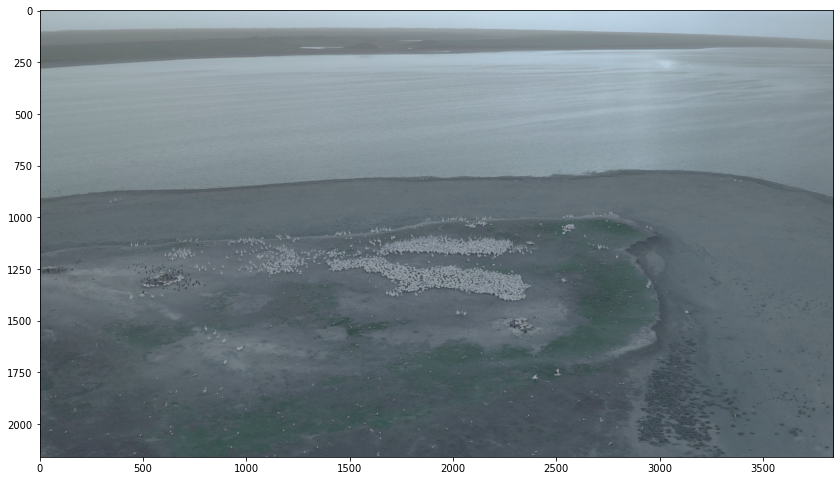

In [85]:
figure, axes = plt.subplots(figsize=(1024 / 72, 1024 / 72), dpi=72)
# axes.imshow(frame[tile.slice])
axes.imshow(frame)
for bbox in normalize_boxes(boxes_total[0], frame, denormalize=True):
# for bbox in boxes_nms:
    axes.add_patch(patches.Rectangle(bbox[:2], *(bbox[2:4] - bbox[:2]), linewidth=1,
                                     edgecolor='pink', facecolor='none'))
plt.show()

In [52]:
len(boxes_norm_)

16128

In [60]:
boxes_norm_[boxes_norm_ < 0].shape

(1437,)

In [71]:
boxes[boxes < 0].shape

(30,)

In [77]:
boxes[0]#[3]

array([3.1877298e+00, 7.1520815e+00, 1.7058611e+01, 2.0230839e+01,
       6.5684319e-05, 9.9999410e-01], dtype=float32)

In [1]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a

NameError: name 'np' is not defined

In [ ]:
b = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b

In [ ]:
np.stack((a, b), axis=0)#.shape

In [ ]:
a[None, ...][0]

In [ ]:
b[0] = 1

In [ ]:
b

In [ ]:
# import math

# from typing import Iterable, List, Sequence, Tuple

# import numpy as np


# def compute_pyramid_patch_weight_loss(width: int, height: int) -> np.ndarray:
#     """Compute a weight matrix that assigns bigger weight on pixels in center and
#     less weight to pixels on image boundary.
#     This weight matrix then used for merging individual tile predictions and helps dealing
#     with prediction artifacts on tile boundaries.
#     :param width: Tile width
#     :param height: Tile height
#     :return: Since-channel image [Width x Height]
#     """
#     xc = width * 0.5
#     yc = height * 0.5
#     xl = 0
#     xr = width
#     yb = 0
#     yt = height
#     Dc = np.zeros((width, height))
#     De = np.zeros((width, height))

#     Dcx = np.square(np.arange(width) - xc + 0.5)
#     Dcy = np.square(np.arange(height) - yc + 0.5)
#     Dc = np.sqrt(Dcx[np.newaxis].transpose() + Dcy)

#     De_l = np.square(np.arange(width) - xl + 0.5) + np.square(0.5)
#     De_r = np.square(np.arange(width) - xr + 0.5) + np.square(0.5)
#     De_b = np.square(0.5) + np.square(np.arange(height) - yb + 0.5)
#     De_t = np.square(0.5) + np.square(np.arange(height) - yt + 0.5)

#     De_x = np.sqrt(np.minimum(De_l, De_r))
#     De_y = np.sqrt(np.minimum(De_b, De_t))
#     De = np.minimum(De_x[np.newaxis].transpose(), De_y)

#     alpha = (width * height) / np.sum(np.divide(De, np.add(Dc, De)))
#     W = alpha * np.divide(De, np.add(Dc, De))
#     return W, Dc, De


# class ImageSlicer:
#     tile_size: Tuple[int, int]
#     tile_step: Tuple[int, int]
#     overlap: Tuple[int, int]

#     """
#     Helper class to slice image into tiles and merge them back. NO BBOXES, MAY WORK WITH MASKS
#     """

#     def __init__(self, image_shape: Tuple[int, int], tile_size, tile_step=0, image_margin=0,
#                  weight="mean"):
#         """
#         :param image_shape: Shape of the source image (H, W)
#         :param tile_size: Tile size (Scalar or tuple (H, W))
#         :param tile_step: Step in pixels between tiles (Scalar or tuple (H, W))
#         :param image_margin:
#         :param weight: Fusion algorithm. 'mean' - avergaing
#         """
#         self.image_height = image_shape[0]
#         self.image_width = image_shape[1]

#         if isinstance(tile_size, (np.ndarray, Sequence)):
#             if len(tile_size) != 2:
#                 raise ValueError(f"Tile size must have exactly 2 elements. Got: tile_size={tile_size}")
#             self.tile_size = int(tile_size[0]), int(tile_size[1])
#         else:
#             self.tile_size = int(tile_size), int(tile_size)

#         if isinstance(tile_step, (np.ndarray, Sequence)):
#             if len(tile_step) != 2:
#                 raise ValueError(f"Tile size must have exactly 2 elements. Got: tile_step={tile_size}")
#             self.tile_step = int(tile_step[0]), int(tile_step[1])
#         else:
#             self.tile_step = int(tile_step), int(tile_step)

#         weights = {"mean": self._mean, "pyramid": self._pyramid}

#         self.weight = weight if isinstance(weight, np.ndarray) else weights[weight](self.tile_size)

#         if self.tile_step[0] < 1 or self.tile_step[0] > self.tile_size[0]:
#             raise ValueError()
#         if self.tile_step[1] < 1 or self.tile_step[1] > self.tile_size[1]:
#             raise ValueError()

#         overlap = (self.tile_size[0] - self.tile_step[0], self.tile_size[1] - self.tile_step[1])

#         self.margin_left = 0
#         self.margin_right = 0
#         self.margin_top = 0
#         self.margin_bottom = 0

#         if image_margin == 0:
#             # In case margin is not set, we compute it manually

#             nw = max(1, math.ceil((self.image_width - overlap[1]) / self.tile_step[1]))
#             nh = max(1, math.ceil((self.image_height - overlap[0]) / self.tile_step[0]))

#             extra_w = self.tile_step[1] * nw - (self.image_width - overlap[1])
#             extra_h = self.tile_step[0] * nh - (self.image_height - overlap[0])

#             self.margin_left = extra_w // 2
#             self.margin_right = extra_w - self.margin_left
#             self.margin_top = extra_h // 2
#             self.margin_bottom = extra_h - self.margin_top

#         else:
#             if isinstance(image_margin, Sequence):
#                 margin_left, margin_right, margin_top, margin_bottom = image_margin
#             else:
#                 margin_left = margin_right = margin_top = margin_bottom = image_margin

#             self.margin_left = margin_left
#             self.margin_right = margin_right
#             self.margin_top = margin_top
#             self.margin_bottom = margin_bottom

#         crops = []
#         bbox_crops = []

#         for y in range(
#             0, self.image_height + self.margin_top + self.margin_bottom - self.tile_size[0] + 1,
#             self.tile_step[0]
#         ):
#             for x in range(
#                 0, self.image_width + self.margin_left + self.margin_right - self.tile_size[1] + 1,
#                 self.tile_step[1]
#             ):
#                 crops.append((x, y, self.tile_size[1], self.tile_size[0]))
#                 bbox_crops.append((x - self.margin_left, y - self.margin_top, self.tile_size[1],
#                                    self.tile_size[0]))

#         self.crops = np.array(crops)
#         self.bbox_crops = np.array(bbox_crops)

#     def iter_split(
#         self, image: np.ndarray, border_type=cv.BORDER_CONSTANT, value=0
#     ) -> Iterable[Tuple[np.ndarray, Tuple[int, int, int, int]]]:
#         if (image.shape[0] != self.image_height) or (image.shape[1] != self.image_width):
#             raise ValueError()

#         orig_shape_len = len(image.shape)

#         for coords, crop_coords in zip(self.crops, self.bbox_crops):
#             x, y, tile_width, tile_height = crop_coords
#             x1 = max(x, 0)
#             y1 = max(y, 0)
#             x2 = min(image.shape[1], x + tile_width)
#             y2 = min(image.shape[0], y + tile_height)

#             tile = image[y1:y2, x1:x2]  # .copy()
#             if x < 0 or y < 0 or (x + tile_width) > image.shape[1] or (y + tile_height) > image.shape[0]:
#                 tile = cv.copyMakeBorder(
#                     tile,
#                     top=max(0, -y),
#                     bottom=max(0, y + tile_height - image.shape[0]),
#                     left=max(0, -x),
#                     right=max(0, x + tile_width - image.shape[1]),
#                     borderType=border_type,
#                     value=value,
#                 )

#                 # This check recovers possible lack of last dummy dimension for single-channel images
#                 if len(tile.shape) != orig_shape_len:
#                     tile = np.expand_dims(tile, axis=-1)

#             yield tile, coords

#     def split(self, image, border_type=cv.BORDER_CONSTANT, value=0):
#         assert image.shape[0] == self.image_height
#         assert image.shape[1] == self.image_width

#         orig_shape_len = len(image.shape)
#         image = cv.copyMakeBorder(
#             image,
#             self.margin_top,
#             self.margin_bottom,
#             self.margin_left,
#             self.margin_right,
#             borderType=border_type,
#             value=value,
#         )

#         # This check recovers possible lack of last dummy dimension for single-channel images
#         if len(image.shape) != orig_shape_len:
#             image = np.expand_dims(image, axis=-1)

#         tiles = []
#         for x, y, tile_width, tile_height in self.crops:
#             tile = image[y : y + tile_height, x : x + tile_width]  # .copy()
#             assert tile.shape[0] == self.tile_size[0]
#             assert tile.shape[1] == self.tile_size[1]

#             tiles.append(tile)

#         return tiles

#     def cut_patch(self, image: np.ndarray, slice_index, border_type=cv.BORDER_CONSTANT, value=0):
#         assert image.shape[0] == self.image_height
#         assert image.shape[1] == self.image_width

#         orig_shape_len = len(image.shape)
#         x, y, tile_width, tile_height = self.bbox_crops[slice_index]

#         x1 = max(x, 0)
#         y1 = max(y, 0)
#         x2 = min(image.shape[1], x + tile_width)
#         y2 = min(image.shape[0], y + tile_height)

#         tile = image[y1:y2, x1:x2]
#         if x < 0 or y < 0 or (x + tile_width) > image.shape[1] or (y + tile_height) > image.shape[0]:
#             tile = cv.copyMakeBorder(
#                 tile,
#                 top=max(0, -y),
#                 bottom=max(0, y + tile_height - image.shape[0]),
#                 left=max(0, -x),
#                 right=max(0, x + tile_width - image.shape[1]),
#                 borderType=border_type,
#                 value=value,
#             )

#             # This check recovers possible lack of last dummy dimension for single-channel images
#             if len(tile.shape) != orig_shape_len:
#                 tile = np.expand_dims(tile, axis=-1)

#         return tile

#     @property
#     def target_shape(self):
#         target_shape = (
#             self.image_height + self.margin_bottom + self.margin_top,
#             self.image_width + self.margin_right + self.margin_left,
#         )
#         return target_shape

#     def merge(self, tiles: List[np.ndarray], dtype=np.float32):
#         if len(tiles) != len(self.crops):
#             raise ValueError

#         channels = 1 if len(tiles[0].shape) == 2 else tiles[0].shape[2]
#         target_shape = (
#             self.image_height + self.margin_bottom + self.margin_top,
#             self.image_width + self.margin_right + self.margin_left,
#             channels,
#         )

#         image = np.zeros(target_shape, dtype=np.float64)
#         norm_mask = np.zeros(target_shape, dtype=np.float64)

#         w = np.dstack([self.weight] * channels)

#         for tile, (x, y, tile_width, tile_height) in zip(tiles, self.crops):
#             # print(x, y, tile_width, tile_height, image.shape)
#             image[y : y + tile_height, x : x + tile_width] += tile * w
#             norm_mask[y : y + tile_height, x : x + tile_width] += w

#         # print(norm_mask.min(), norm_mask.max())
#         norm_mask = np.clip(norm_mask, a_min=np.finfo(norm_mask.dtype).eps, a_max=None)
#         normalized = np.divide(image, norm_mask).astype(dtype)
#         crop = self.crop_to_orignal_size(normalized)
#         return crop

#     def crop_to_orignal_size(self, image):
#         assert image.shape[0] == self.target_shape[0]
#         assert image.shape[1] == self.target_shape[1]
#         crop = image[
#             self.margin_top : self.image_height + self.margin_top,
#             self.margin_left : self.image_width + self.margin_left,
#         ]
#         assert crop.shape[0] == self.image_height
#         assert crop.shape[1] == self.image_width
#         return crop

#     def _mean(self, tile_size):
#         return np.ones((tile_size[0], tile_size[1]), dtype=np.float32)

#     def _pyramid(self, tile_size):
#         w, _, _ = compute_pyramid_patch_weight_loss(tile_size[0], tile_size[1])
#         return w


In [ ]:
# assert False

In [ ]:
# import math as m


# def get_tile_step(image_shape, tile_size):
#     height, width = image_shape[:2]
#     num_patches_x = m.ceil(width / tile_size)
#     num_patches_y = m.ceil(height / tile_size)
#     shifts_x = None
#     shifts_y = None
#     print(f"Size = {(width, height)}, num patches = {(num_patches_x, num_patches_y)}")
#     offset_x = 0
#     for i in range(num_patches_x):
#         offset_y = 0
#         for j in range(num_patches_y):
#             # print(f"Patch {(i, j)} {(offset_x, offset_y, offset_x + tile_size, offset_y + tile_size)}")
#             # Update y-offset (end of iteration)
#             shift_y = ((num_patches_y - j) - (height - offset_y) / tile_size) / (num_patches_y - j - 1 + 1e-15)
#             shifts_y = shifts_y or shift_y
#             offset_y += round(tile_size - tile_size * shift_y)
#             pass
#         # Update x-offset (end of iteration)
#         shift_x = ((num_patches_x - i) - (width - offset_x) / tile_size) / (num_patches_x - i - 1 + 1e-15)
#         shifts_x = shifts_x or shift_x
#         offset_x += round(tile_size - tile_size * shift_x)
#         # print(shifts_x, shifts_y)
#     return tile_size - tile_size * shifts_y, tile_size - tile_size * shifts_x

In [ ]:
# boxes = []

# for filename in glob(osp.join(PATH_DATA, '*')):
#     video = cv.VideoCapture(filename)
#     if video.isOpened():
#         height, width = video.get(cv.CAP_PROP_FRAME_HEIGHT), video.get(cv.CAP_PROP_FRAME_WIDTH)
#         step_y, step_x = get_tile_step((height, width), SIZE)
#         print(f"Tile steps = {step_y, step_x}")
#         while True:
#             ok, frame = video.read()
#             if not ok:
#                 break
#             # slices = ImageSlicer(image_shape=frame.shape[:2], tile_size=SIZE, tile_step=(step_y, step_x))
#             # slices.split(frame)
#             # for image, coordinates in slices.iter_split(frame):
#             #     print(f"Tile coordinates = {coordinates}")
#             image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
#             batch = np.moveaxis(image, -1, 0)[None, ...] / np.float32(255)
#             boxes += session.run(None, {session.get_inputs()[0].name: batch})[0][0]
#             break
#     video.release()
#     break

In [ ]:
def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()

    for t in range(len(boxes)):

        if len(boxes[t]) != len(scores[t]):
            print('Error. Length of boxes arrays not equal to length of scores array: {} != {}'.format(len(boxes[t]), len(scores[t])))
            exit()

        if len(boxes[t]) != len(labels[t]):
            print('Error. Length of boxes arrays not equal to length of labels array: {} != {}'.format(len(boxes[t]), len(labels[t])))
            exit()

        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            x1 = float(box_part[0])
            y1 = float(box_part[1])
            x2 = float(box_part[2])
            y2 = float(box_part[3])

            # Box data checks
            if x2 < x1:
                warnings.warn('X2 < X1 value in box. Swap them.')
                x1, x2 = x2, x1
            if y2 < y1:
                warnings.warn('Y2 < Y1 value in box. Swap them.')
                y1, y2 = y2, y1
            if x1 < 0:
                warnings.warn('X1 < 0 in box. Set it to 0.')
                x1 = 0
            if x1 > 1:
                warnings.warn('X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x1 = 1
            if x2 < 0:
                warnings.warn('X2 < 0 in box. Set it to 0.')
                x2 = 0
            if x2 > 1:
                warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x2 = 1
            if y1 < 0:
                warnings.warn('Y1 < 0 in box. Set it to 0.')
                y1 = 0
            if y1 > 1:
                warnings.warn('Y1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y1 = 1
            if y2 < 0:
                warnings.warn('Y2 < 0 in box. Set it to 0.')
                y2 = 0
            if y2 > 1:
                warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y2 = 1
            if (x2 - x1) * (y2 - y1) == 0.0:
                warnings.warn("Zero area box skipped: {}.".format(box_part))
                continue

            # [label, score, weight, model index, x1, y1, x2, y2]
            b = [int(label), float(score) * weights[t], weights[t], t, x1, y1, x2, y2]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box (label, score, weight, model index, x1, y1, x2, y2)
    """

    box = np.zeros(8, dtype=np.float32)
    conf = 0
    conf_list = []
    w = 0
    for b in boxes:
        box[4:] += (b[1] * b[4:])
        conf += b[1]
        conf_list.append(b[1])
        w += b[2]
    box[0] = boxes[0][0]
    if conf_type in ('avg', 'box_and_model_avg', 'absent_model_aware_avg'):
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    box[2] = w
    box[3] = -1 # model index field is retained for consistency but is not used.
    box[4:] /= conf
    return box


def find_matching_box_fast(boxes_list, new_box, match_iou):
    """
        Reimplementation of find_matching_box with numpy instead of loops. Gives significant speed up for larger arrays
        (~100x). This was previously the bottleneck since the function is called for every entry in the array.
    """
    def bb_iou_array(boxes, new_box):
        # bb interesection over union
        xA = np.maximum(boxes[:, 0], new_box[0])
        yA = np.maximum(boxes[:, 1], new_box[1])
        xB = np.minimum(boxes[:, 2], new_box[2])
        yB = np.minimum(boxes[:, 3], new_box[3])

        interArea = np.maximum(xB - xA, 0) * np.maximum(yB - yA, 0)

        # compute the area of both the prediction and ground-truth rectangles
        boxAArea = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        boxBArea = (new_box[2] - new_box[0]) * (new_box[3] - new_box[1])

        iou = interArea / (boxAArea + boxBArea - interArea)

        return iou

    if boxes_list.shape[0] == 0:
        return -1, match_iou

    # boxes = np.array(boxes_list)
    boxes = boxes_list

    ious = bb_iou_array(boxes[:, 4:], new_box[4:])

    ious[boxes[:, 0] != new_box[0]] = -1

    best_idx = np.argmax(ious)
    best_iou = ious[best_idx]

    if best_iou <= match_iou:
        best_iou = match_iou
        best_idx = -1

    return best_idx, best_iou


def weighted_boxes_fusion(
        boxes_list,
        scores_list,
        labels_list,
        weights=None,
        iou_thr=0.55,
        skip_box_thr=0.0,
        conf_type='avg',
        allows_overflow=False
):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers.
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param iou_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable
    :param conf_type: how to calculate confidence in weighted boxes.
        'avg': average value,
        'max': maximum value,
        'box_and_model_avg': box and model wise hybrid weighted average,
        'absent_model_aware_avg': weighted average that takes into account the absent model.
    :param allows_overflow: false if we want confidence score not exceed 1.0
    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2).
    :return: scores: confidence scores
    :return: labels: boxes labels
    '''

    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max', 'box_and_model_avg', 'absent_model_aware_avg']:
        print('Unknown conf_type: {}. Must be "avg", "max" or "box_and_model_avg", or "absent_model_aware_avg"'.format(conf_type))
        exit()

    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,))

    overall_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = np.empty((0, 8))

        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box_fast(weighted_boxes, boxes[j], iou_thr)

            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes = np.vstack((weighted_boxes, boxes[j].copy()))

        # Rescale confidence based on number of models and boxes
        for i in range(len(new_boxes)):
            clustered_boxes = new_boxes[i]
            if conf_type == 'box_and_model_avg':
                clustered_boxes = np.array(clustered_boxes)
                # weighted average for boxes
                weighted_boxes[i, 1] = weighted_boxes[i, 1] * len(clustered_boxes) / weighted_boxes[i, 2]
                # identify unique model index by model index column
                _, idx = np.unique(clustered_boxes[:, 3], return_index=True)
                # rescale by unique model weights
                weighted_boxes[i, 1] = weighted_boxes[i, 1] *  clustered_boxes[idx, 2].sum() / weights.sum()
            elif conf_type == 'absent_model_aware_avg':
                clustered_boxes = np.array(clustered_boxes)
                # get unique model index in the cluster
                models = np.unique(clustered_boxes[:, 3]).astype(int)
                # create a mask to get unused model weights
                mask = np.ones(len(weights), dtype=bool)
                mask[models] = False
                # absent model aware weighted average
                weighted_boxes[i, 1] = weighted_boxes[i, 1] * len(clustered_boxes) / (weighted_boxes[i, 2] + weights[mask].sum())
            elif conf_type == 'max':
                weighted_boxes[i, 1] = weighted_boxes[i, 1] / weights.max()
            elif not allows_overflow:
                weighted_boxes[i, 1] = weighted_boxes[i, 1] * min(len(weights), len(clustered_boxes)) / weights.sum()
            else:
                weighted_boxes[i, 1] = weighted_boxes[i, 1] * len(clustered_boxes) / weights.sum()
        overall_boxes.append(weighted_boxes)
    overall_boxes = np.concatenate(overall_boxes, axis=0)
    overall_boxes = overall_boxes[overall_boxes[:, 1].argsort()[::-1]]
    boxes = overall_boxes[:, 4:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    return boxes, scores, labels

In [ ]:
import math as m


# boxes = []
# tile_size = SIZE

def nms_yolo(boxes, thresh):
    '''
    boxes is a numpy array : {n, {x, y, w, h, s, c}}
    thresh is a float: NMS threshold
    '''
    boxes = boxes.copy()

    # x, y, w, h -> x1, y1, x2, y2
    boxes[:, 0] -= boxes[:, 2] / 2
    boxes[:, 1] -= boxes[:, 3] / 2

    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]

    scores = boxes[:, 4]

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1] # get boxes with more ious first

    keep = []
    while order.size > 0:
        i = order[0] # pick maxmum iou box
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1) # maximum width
        h = np.maximum(0.0, yy2 - yy1 + 1) # maxiumum height
        area = w * h
        overlap = area / (areas[i] + areas[order[1:]] - area)

        indices = np.where(overlap <= thresh)[0]
        order = order[indices + 1]

    boxes = boxes[keep]

    # x1, y1, x2, y2 -> x, y, w, h
    # boxes[:, 2] -= boxes[:, 0]
    # boxes[:, 3] -= boxes[:, 1]

    # boxes[:, 0] += boxes[:, 2] / 2
    # boxes[:, 1] += boxes[:, 3] / 2

    return boxes  # [boxes[:, 4] >= thresh]


# indices = nms_yolo(boxes_abs[:, :4], boxes_abs[:, 4], 0.175)

# len(indices)

# boxes_sorted = boxes_abs[indices]

# len(boxes_sorted[boxes_sorted[:, 4] >= threshold_nms])

def inference_tiles(session, image, tile_size):
    height, width = image.shape[:2]
    num_patches_x = m.ceil(width / tile_size)
    num_patches_y = m.ceil(height / tile_size)
    bboxes = {}
    # print(f"Size = {(width, height)}, num patches = {(num_patches_x, num_patches_y)}")
    offset_x = 0
    for i in range(num_patches_x):
        offset_y = 0
        for j in range(num_patches_y):
            # print(f"Patch {(i, j)} {(offset_x, offset_y, offset_x + tile_size, offset_y + tile_size)}")
            # Update y-offset (end of iteration)
            shift_y = ((num_patches_y - j) - (height - offset_y) / tile_size) / (num_patches_y - j - 1 + 1e-15)
            offset_y += round(tile_size - tile_size * shift_y)
            batch = np.moveaxis(image, -1, 0)[None, ...] / np.float32(255)
            predictions = session.run(None, {session.get_inputs()[0].name: batch})[0][0]
            print(f"Patch {i, j}: {len(predictions)} predictions (no NMS)")
            predictions = nms_yolo(predictions, 0.25)
            print(f"Patch {i, j}: {len(predictions)} predictions (with NMS)")
            # Filter border-overlap boxes
            index_border_overlap = (((predictions[:, 0] <= 0) & (i > 0)) |
                                    ((predictions[:, 1] <= 0) & (j > 0)) |
                                    ((predictions[:, 2] >= tile_size) & (i < (num_patches_x - 1))) |
                                    ((predictions[:, 3] >= tile_size) & (j < (num_patches_y - 1))))
            print(f"{i, j} overlaps = {index_border_overlap.sum()}")
            predictions = predictions[~index_border_overlap]
            # Patch box position (relative) to image box position (absolute)
            predictions[:, 0:4:2] += offset_x
            predictions[:, 1:4:2] += offset_y
            boxes = {
                (i, j): {
                    'predictions': predictions,
                    'offset_x': offset_x,
                    'offset_y': offset_y
                }
            }
        # Update x-offset (end of iteration)
        shift_x = ((num_patches_x - i) - (width - offset_x) / tile_size) / (num_patches_x - i - 1 + 1e-15)
        offset_x += round(tile_size - tile_size * shift_x)
    return boxes

def wbf(outputs, weights, thresh_iou, thresh_conf, conf_type='max'):
    # Sort by score
    boxes_clusters = []
    boxes_fused = []
    boxes =[]
    
    return boxes

for filename in glob(osp.join(PATH_DATA, '*')):
    video = cv.VideoCapture(filename)
    if video.isOpened():
        height, width = video.get(cv.CAP_PROP_FRAME_HEIGHT), video.get(cv.CAP_PROP_FRAME_WIDTH)
        step_y, step_x = get_tile_step((height, width), SIZE)
        print(f"Tile steps = {step_y, step_x}")
        while True:
            ok, frame = video.read()
            if not ok:
                break
            # slices = ImageSlicer(image_shape=frame.shape[:2], tile_size=SIZE, tile_step=(step_y, step_x))
            # slices.split(frame)
            # for image, coordinates in slices.iter_split(frame):
            #     print(f"Tile coordinates = {coordinates}")
            image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            # batch = np.moveaxis(image, -1, 0)[None, ...] / np.float32(255)
            # boxes += session.run(None, {session.get_inputs()[0].name: batch})[0][0]
            boxes = inference_tiles(session, image, SIZE)
            boxes = wbf(np.array([box['predictions'] for box in boxes], np.array([1] * len(boxes)))
            break
    video.release()
    break